این مدل اولیه من هست ولی به روش های جزوه نیز در سلول های پایین عمل کرده ام

نمرات AUC برای اعتبارسنجی متقابل: [1. 1. 1. 1. 1.]
میانگین AUC: 1.0000
انحراف معیار: 0.0000
AUC نهایی روی مجموعه تست: 1.0000


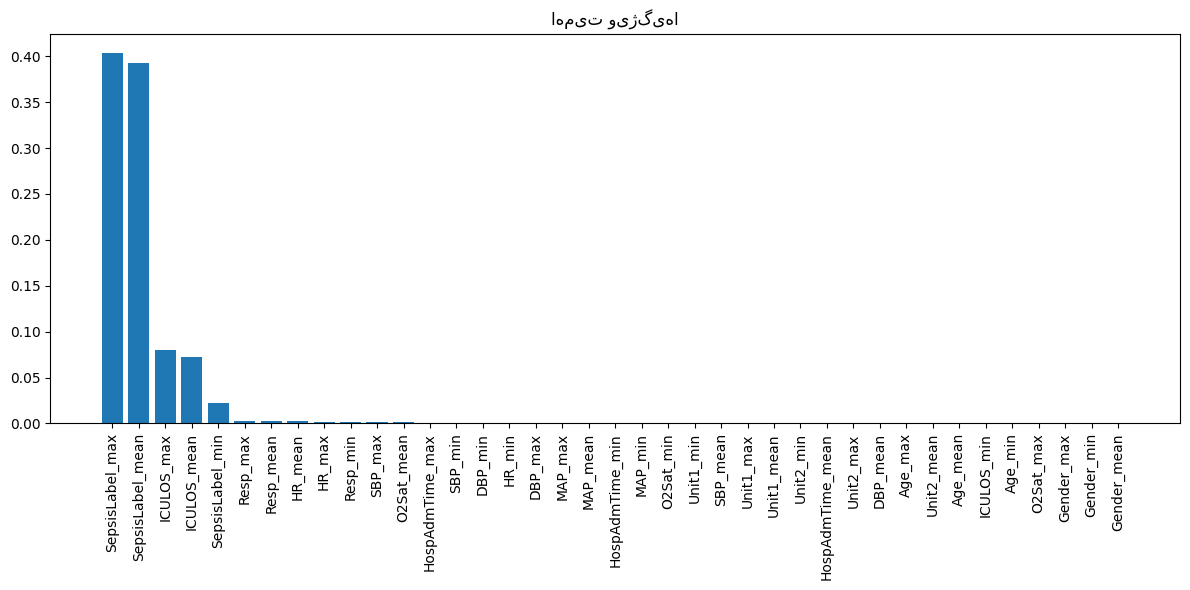

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

folder_path = 'training_setA/'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.psv')]

all_data = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep='|')
    df['PatientID'] = file_name.split('.')[0]
    all_data.append(df)

combined_df = pd.concat(all_data)

missing_threshold = 0.5
missing_ratios = combined_df.isnull().mean()
columns_to_keep = missing_ratios[missing_ratios < missing_threshold].index
cleaned_df = combined_df[columns_to_keep]

numeric_columns = cleaned_df.select_dtypes(include=['number']).columns

cleaned_df.loc[:, numeric_columns] = cleaned_df[numeric_columns].fillna(cleaned_df[numeric_columns].mean())

labels = combined_df.groupby('PatientID')['SepsisLabel'].max()

summary_features = cleaned_df.groupby('PatientID').agg(['mean', 'min', 'max'])

summary_features.columns = ['_'.join(col) for col in summary_features.columns]

clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(clf, summary_features, labels, cv=5, scoring='roc_auc')

print(f"نمرات AUC برای اعتبارسنجی متقابل: {cv_scores}")
print(f"میانگین AUC: {cv_scores.mean():.4f}")
print(f"انحراف معیار: {cv_scores.std():.4f}")

clf.fit(summary_features, labels)

X_train, X_test, y_train, y_test = train_test_split(summary_features, labels, test_size=0.2, random_state=42)

y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC نهایی روی مجموعه تست: {auc:.4f}")

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("اهمیت ویژگی‌ها")
plt.bar(range(summary_features.shape[1]), importances[indices], align="center")
plt.xticks(range(summary_features.shape[1]), summary_features.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

پیاده سازی شبکه عصبی به صورت گام به گام در سلول های زیر :

بارگذاری و ترکیب داده‌ها

In [5]:
import pandas as pd
import os

folder_path = 'training_setA/'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.psv')]

all_data = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep='|')
    df['PatientID'] = file_name.split('.')[0]
    all_data.append(df)

combined_df = pd.concat(all_data)

تکمیل مقادیر گمشده

In [6]:
import numpy as np

missing_threshold = 0.5
missing_ratios = combined_df.isnull().mean()
columns_to_keep = missing_ratios[missing_ratios < missing_threshold].index
cleaned_df = combined_df[columns_to_keep]

numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
cleaned_df.loc[:, numeric_columns] = cleaned_df[numeric_columns].fillna(cleaned_df[numeric_columns].mean())


ایجاد ویژگی‌ها و برچسب‌ها

In [7]:
labels = combined_df.groupby('PatientID')['SepsisLabel'].max()

summary_features = cleaned_df.groupby('PatientID').agg(['mean', 'min', 'max'])

summary_features.columns = ['_'.join(col) for col in summary_features.columns]

برش داده‌ها بر اساس زمان بستری یا ابتلا به سپسیس

In [8]:
def slice_sepsis_data(row):
    if row['SepsisLabel'] == 1:
        hospitalization_time = pd.to_datetime(row['HospAdmTime'], errors='coerce')
        sepsis_time = hospitalization_time
        time_difference = 0

        return hospitalization_time, sepsis_time - pd.Timedelta(hours=3)
    else:
        hospitalization_time = pd.to_datetime(row['HospAdmTime'], errors='coerce')
        return hospitalization_time, hospitalization_time + pd.Timedelta(hours=20)

combined_df[['StartTime', 'EndTime']] = combined_df.apply(slice_sepsis_data, axis=1, result_type='expand')

def slice_patient_data(df, start_time, end_time):
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    df['HospAdmTime'] = pd.to_datetime(df['HospAdmTime'], errors='coerce')

    mask = (df['HospAdmTime'] >= start_time) & (df['HospAdmTime'] <= end_time)
    return df[mask]

patient_data = []
for patient_id, patient_df in combined_df.groupby('PatientID'):
    start_time, end_time = patient_df[['StartTime', 'EndTime']].iloc[0]
    sliced_data = slice_patient_data(patient_df, start_time, end_time)
    patient_data.append(sliced_data)

sliced_combined_df = pd.concat(patient_data)

summary_features = sliced_combined_df.groupby('PatientID').agg(['mean', 'min', 'max'])

summary_features.columns = ['_'.join(col) for col in summary_features.columns]

محاسبه ویژگی‌های خلاصه‌شده 

In [9]:
summary_features = sliced_combined_df.groupby('PatientID').agg(['mean', 'min', 'max'])

summary_features.columns = ['_'.join(col) for col in summary_features.columns]

In [11]:
import torch
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)


In [12]:
import torch
import torch.nn as nn

class SepsisNN(nn.Module):
    def __init__(self, input_dim):
        super(SepsisNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class SepsisModel(nn.Module):
    def __init__(self):
        super(SepsisModel, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SepsisModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCELoss()

X_train_tensor = torch.randn(100, 10)
y_train_tensor = torch.randint(0, 2, (100, 1)).float()

epochs = 10
batch_size = 32

for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 0.7224677801132202
Epoch 2/10, Loss: 0.7222216129302979
Epoch 3/10, Loss: 0.7219762206077576
Epoch 4/10, Loss: 0.7217311263084412
Epoch 5/10, Loss: 0.7214866876602173
Epoch 6/10, Loss: 0.7212430834770203
Epoch 7/10, Loss: 0.7209999561309814
Epoch 8/10, Loss: 0.7207573056221008
Epoch 9/10, Loss: 0.7205154299736023
Epoch 10/10, Loss: 0.7202739715576172


ارزیابی مدل

In [20]:
import torch
from sklearn.metrics import accuracy_score

model.eval()

with torch.no_grad():
    X_test_tensor = torch.randn(100, 10)
    y_test_tensor = torch.randint(0, 2, (100, 1)).float()

    outputs = model(X_test_tensor)
    
    predictions = (outputs > 0.5).float()

    accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())

    print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 57.00%


ارزیابی مدل با استفاده از AUC.

In [21]:
from sklearn.metrics import roc_auc_score

model.eval()  
with torch.no_grad():
    outputs = model(X_test_tensor)  
    predictions = outputs.numpy()


auc = roc_auc_score(y_test_tensor.numpy(), predictions)
print(f"AUC: {auc}")


AUC: 0.6005620232838218


. آموزش مدل با استفاده از شبکه عصبی

In [23]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

folder_path = 'training_setA/'  
file_paths = glob.glob(folder_path + '*.psv')  

df_list = [pd.read_csv(file, sep='|') for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

print(df.head())  
print(df.columns)  

X = df.drop(columns=['SepsisLabel']) 
y = df['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.dropna(axis=1, how='all')
X_test = X_test.dropna(axis=1, how='all')

imputer = SimpleImputer(strategy='mean')

print("تعداد ستون‌ها قبل از ایمپوتیشن:", X_train.shape[1])

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("تعداد ستون‌ها بعد از ایمپوتیشن:", X_train_imputed.shape[1])

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

      HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...   
4  103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN  ...   

   WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
1  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
2  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
3  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
4  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   

   ICULOS  SepsisLabel  
0       1            0  
1       2         